In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch, torch.nn as nn
import torch.nn.functional as F
#from torch.autograd import Variable
print(torch.__version__)

0.4.0


In [2]:
import pickle

In [3]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [4]:
class ConvPID(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_ECAL = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            Flatten(),
            nn.Linear(256, 256)
        )
        self.conv_HCAL = nn.Sequential(
            nn.Conv2d(2, 8, kernel_size=2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            Flatten(),
            nn.Linear(256, 256)
        )
        self.conv_MUON = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            Flatten(),
            nn.Linear(256, 256)
        )
        
        self.dense = nn.Linear(768, 512)
        self.dropout = nn.Dropout(0.5)
        self.output = nn.Linear(512, 3)
        
    def forward(self, pics):
        ecal_dense = self.conv_ECAL(pics[:, :1])
        hcal_dense = self.conv_HCAL(pics[:, 1:3])
        muon_dense = self.conv_MUON(pics[:, 3:])
        
        #ecal_full = torch.cat([ecal])
        
        out = torch.cat([ecal_dense, hcal_dense, muon_dense], dim=-1)
        
        #print(out.shape)
        return self.output(self.dropout(self.dense(out)))

In [5]:
def read_file(filename):
    with open("DET_RESPONDS/1_20_ALL/" + filename, 'rb') as f:
        responses = pickle.load(f, encoding='latin1')
    
    
    det_responses = np.zeros((len(responses), 7, 20, 20))
    momentum = np.zeros((len(responses), 3))
    labels = np.ones(len(responses))
    
    if "mu" in filename:
        labels *= 0
    elif "had" in filename:
        labels *= 2
    
    index = 0
    for key, value in responses.items():
        det_responses[index, 0] = value['ECAL'][0]

        det_responses[index, 1:3] = value['HCAL'][0]

        det_responses[index, 3:] = value['MUON'][0]

        for det_i, det in enumerate(['ECAL', 'HCAL', 'MUON']):
            mom = value[det][1]
            mom = mom if mom is not None else -1
            momentum[index, det_i] = mom

        index += 1
    return det_responses, momentum, labels

#### Check files

In [6]:
responses, momentum, label = read_file("ele.pkl")

[16.30039943 16.10536    -1.        ]


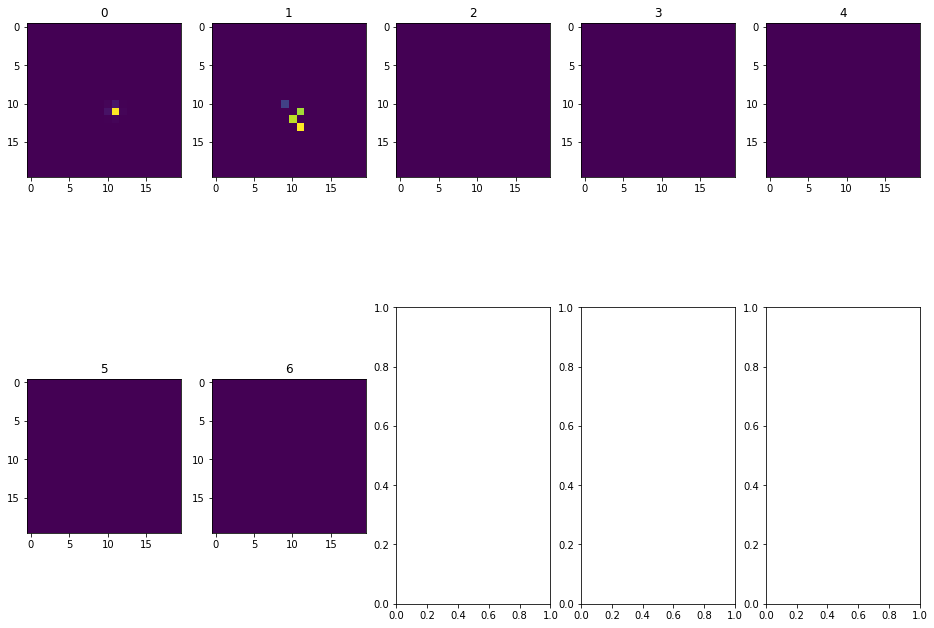

In [19]:
index = 45
print(momentum[index])
f, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,12))
for i, ax in enumerate(axes.ravel()):
    if i == 7:
        break
    ax.imshow(responses[index, i])
    ax.set_title(str(i))

In [20]:
X_data = None
y_data = None

In [21]:
#list_of_file = ['ele.pkl', 'mu_5.pkl', 'mu_8.pkl']
#list_of_file = ['had.pkl', 'ele.pkl', 'mu_5.pkl', 'mu_8.pkl', 'mu_1.5.pkl', 'mu_3.pkl']
list_of_file= ['ele.pkl', 'had.pkl', 'mu.pkl']

In [22]:
!ls DET_RESPONDS/1_20_ALL/

ele.pkl  had.pkl  mu.pkl


In [23]:
for filename in list_of_file:
    responses, momentum, label = read_file(filename)
    empty_events_ind = (responses == 0).all(axis=(1,2,3))
    print("Len of empty pics events: {}".format(empty_events_ind.sum()))
    print("N event with -1 momentum: {}".format((momentum == -1).all(axis=-1).sum()))
    
    responses, momentum, label = responses[~empty_events_ind], momentum[~empty_events_ind],\
                                 label[~empty_events_ind]
    if X_data is None:
        X_data = responses
        y_data = label
        m_data = momentum
    else:
        X_data = np.vstack((X_data, responses))
        y_data = np.hstack((y_data, label))
        m_data = np.vstack((m_data, momentum))

Len of empty pics events: 23
N event with -1 momentum: 23
Len of empty pics events: 28
N event with -1 momentum: 28
Len of empty pics events: 22
N event with -1 momentum: 22


In [24]:
print((y_data == 0).sum())
print((y_data == 1).sum())
print((y_data == 2).sum())

2978
2977
2956


In [120]:
from sklearn.model_selection import train_test_split

In [121]:
X_train, X_val, y_train, y_val, m_train, m_val = train_test_split(X_data, y_data, m_data,
                                                                  test_size=0.1, random_state=1543)

In [122]:
for index in range(3):
    print((y_val == index).sum())

273
298
321


In [123]:
print(X_train.shape, X_val.shape)

(8019, 7, 20, 20) (892, 7, 20, 20)


# Low energy study

In [51]:
low_m_hadrons = np.logical_and(m_data[:, 0] < 1.5, y_data == 2)
low_m_muons = np.logical_and(m_data[:, 0] < 1.5, y_data == 0)

In [100]:
print(low_m_muons.sum())
print(np.where(low_m_muons)[0])

72
[5937 6008 6102 6145 6153 6316 6347 6348 6430 6443 6464 6482 6496 6507
 6546 6602 6666 6680 6727 6807 6868 6908 6987 7066 7110 7196 7232 7238
 7244 7278 7288 7343 7358 7416 7505 7556 7584 7601 7661 7670 7744 7774
 7837 7982 8013 8087 8111 8115 8123 8153 8193 8195 8218 8276 8296 8383
 8478 8499 8530 8536 8550 8591 8595 8604 8682 8732 8737 8758 8774 8864
 8892 8901]


In [53]:
print(low_m_hadrons.sum())
print(np.where(low_m_hadrons)[0])

94
[2980 2983 3011 3112 3118 3128 3186 3214 3246 3334 3336 3369 3405 3457
 3521 3545 3551 3558 3578 3581 3590 3598 3602 3690 3703 3729 3785 3808
 3872 3913 3922 3924 3946 3955 3984 3999 4018 4140 4148 4202 4220 4283
 4285 4328 4415 4417 4439 4443 4476 4518 4558 4587 4616 4657 4676 4697
 4811 4894 4897 4917 4939 4944 4984 5091 5101 5117 5160 5232 5233 5348
 5374 5384 5408 5420 5426 5462 5490 5523 5575 5635 5636 5651 5677 5678
 5679 5702 5721 5729 5756 5770 5843 5848 5849 5895]


In [109]:
diff_m = 

In [110]:
diff_m

[[]]

In [118]:
diff_h = [[], []]
diff_m = [[], []]
for index in np.where(low_m_muons)[0]:
    row, col = np.where(X_data[index, 0])
    diff_m[0].append(np.max(row) - np.min(row))
    diff_m[1].append(np.max(col) - np.min(col))
    
for index in np.where(low_m_hadrons)[0]:
    row, col = np.where(X_data[index, 0])
    diff_h[0].append(np.max(row) - np.min(row))
    diff_h[1].append(np.max(col) - np.min(col))
diff_h = np.array(diff_h)
diff_m = np.array(diff_m)

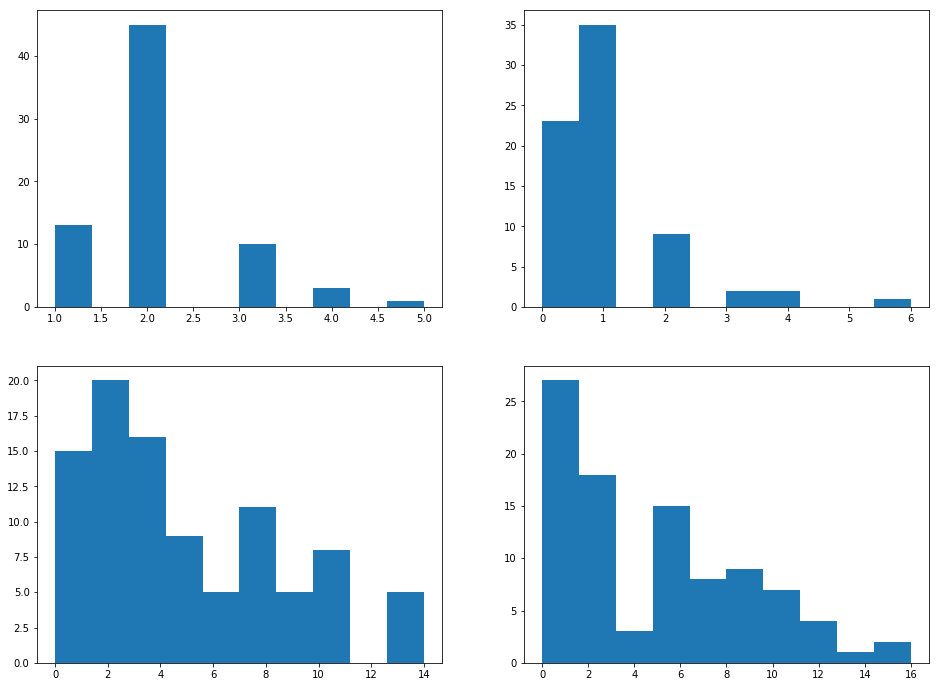

In [119]:
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,12))
axes[0,0].hist(diff_m[0, :]);
axes[0,1].hist(diff_m[1, :]);
axes[1,0].hist(diff_h[0, :]);
axes[1,1].hist(diff_h[1, :]);

(array([12, 13]), array([14, 11]))
[ 1.29164485 -1.         -1.        ] 2.0 1.0160929722331127


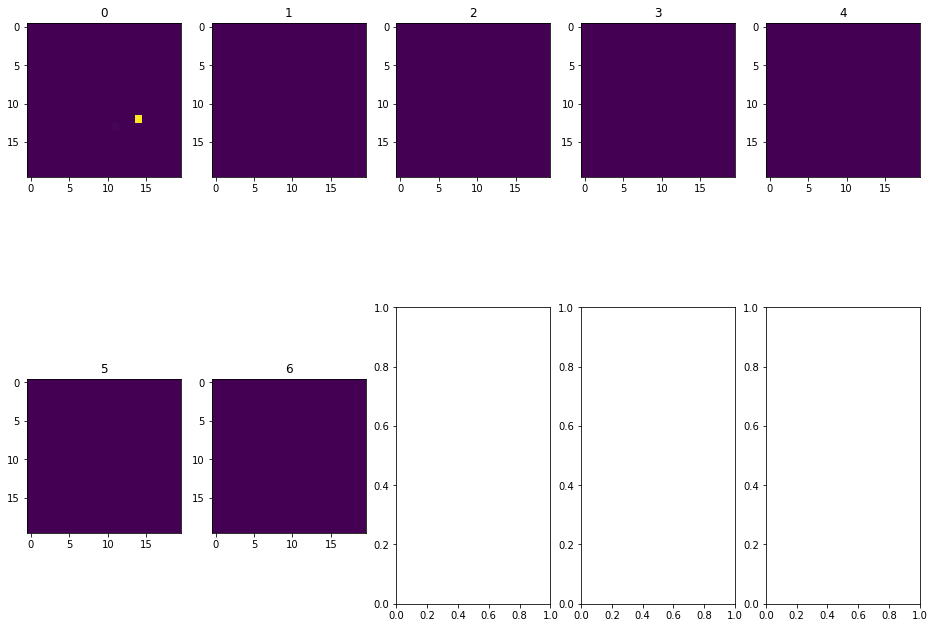

In [126]:
index = 2980
print(np.where(X_data[index, 0]))
print(m_data[index], y_data[index], X_data[index, 0].sum())
f, axes = plt.subplots(nrows=2, ncols=5, figsize=(16,12))
for i, ax in enumerate(axes.ravel()):
    if i == 7:
        break
    ax.imshow(X_data[index, i])
    ax.set_title(str(i))

#  Train net

In [282]:
from tqdm import trange
def iterate_minibatches(X, y, batchsize, shuffle=False):
    indices = np.arange(len(X))
    if shuffle: 
        indices = np.random.permutation(indices)
    for start in trange(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [283]:
model = ConvPID()

In [284]:
import time
from pandas import ewma
from IPython import display        
        
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 40
batch_size = 128

train_loss = []
val_accuracy = []

In [292]:
opt = torch.optim.Adam(model.parameters(), lr=1e-4 / 2)

In [285]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.FloatTensor(X_batch).to(device)
    y_batch = torch.LongTensor(y_batch).to(device)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

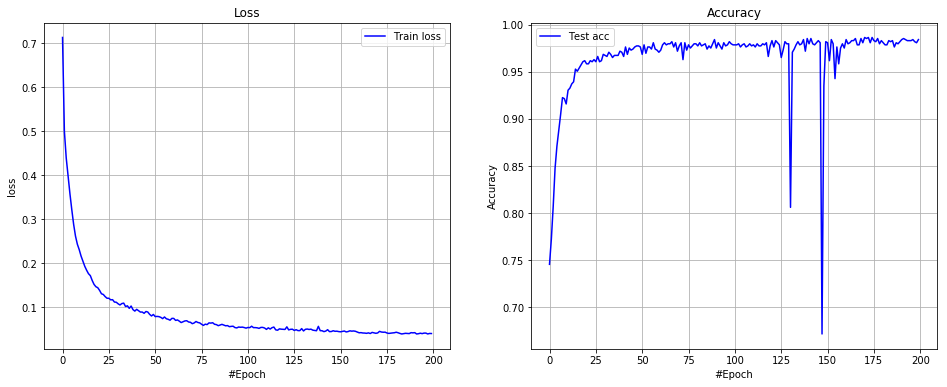

Epoch 40 of 40 took 2.206s
  training loss (in-iteration): 	0.040567
  validation accuracy:		98.43 %


In [293]:
device = torch.device("cpu")

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True)
    
    epoch_loss = 0
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=True):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        epoch_loss += loss.item()
        
    train_loss.append(epoch_loss / (len(X_train) // batch_size + 1))
        
        
    y_score = []
    with torch.no_grad():
        model.train(False)
        for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size, shuffle=False):
            logits = model(torch.FloatTensor(X_batch).to(device))
            y_pred = logits.max(dim=1)[1].detach().numpy()
            #val_accuracy.append(np.mean(y_batch == y_pred))
            y_score.extend(y_pred)
    
    y_score = np.asarray(y_score)
    val_accuracy.append(np.mean(y_score == y_val))
    # Visualize
    
    display.clear_output(wait=True)
    #plt.figure(figsize=(8, 6))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
    ax1.set_title("Loss")
    ax1.set_xlabel("#Epoch")
    ax1.set_ylabel("loss")
    ax1.plot(train_loss, 'b', label='Train loss')
    #ax1.plot(ewma(train_loss, span=10), 'r', label='ewma')
    #ax1.plot(ewma(np.array(train_loss), span=10),'r',label='ewm val loss')
    ax1.legend(loc='best')
    ax1.grid()

    ax2.set_title("Accuracy")
    ax2.set_xlabel("#Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.plot(val_accuracy, 'b', label='Test acc')
    #ax2.plot(ewma(val_accuracy, span=10), 'r', label='test ewma')
    #ax2.plot(ewma(np.array(val_loss), span=10),'r',label='ewm val acc')
    ax2.legend(loc='best')
    ax2.grid()    

    plt.show()
            
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        train_loss[-1]))
    print("  validation accuracy:\t\t{:.2f} %".format(val_accuracy[-1] * 100))

In [294]:
model.eval()
predictions = model(torch.FloatTensor(X_val).to(device)).max(dim=1)[1].detach().numpy()

In [295]:
np.mean((predictions == y_val))

0.984304932735426

In [296]:
y_val.shape

(892,)

In [232]:
(y_val == 2).sum()

48

In [297]:
from collections import Counter
count = Counter()

In [298]:
count.update(y_val[(predictions != y_val)])

In [299]:
count

Counter({0.0: 7, 1.0: 3, 2.0: 4})

In [338]:
misident_ind = np.where(predictions != y_val)[0]
misident_ind

array([ 46,  55,  67,  76, 216, 290, 540, 591, 603, 694, 698, 713, 717,
       823])

In [323]:
index = 591

In [219]:
# initially_zero_evnts = (X_val[misident_ind, ...] == 0).all(axis=(1,2,3))
# print(initially_zero_evnts.sum())
# initially_zero_evnts

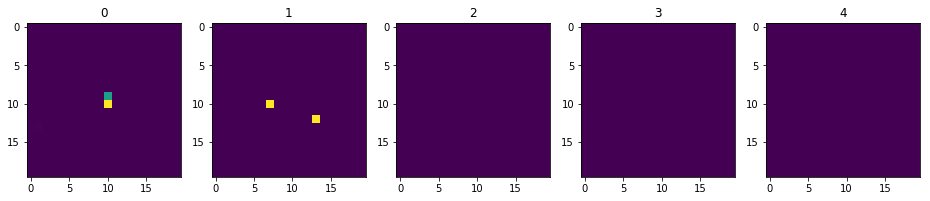

In [324]:
f, axes = plt.subplots(nrows=1, ncols=5, figsize=(16,12))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X_val[index, i])
    ax.set_title(str(i))

In [325]:
predictions[index]

0

In [326]:
y_val[index]

2.0

In [327]:
F.softmax(model(torch.FloatTensor(X_val).to(device))[index], dim=0)

tensor([ 9.9556e-01,  1.8931e-11,  4.4416e-03])

In [328]:
m_val[index]

array([16.95574604, 16.75985153, 16.75985153])

In [335]:
low_m_muons = np.logical_and(np.linalg.norm(m_val, axis=1) < 3, y_val == 0)

In [345]:
np.where(low_m_muons)[0].shape

(12,)

In [346]:
np.isin(np.where(low_m_muons)[0],misident_ind).sum()

4

In [336]:
np.linalg.norm(m_val, axis=1)[low_m_muons]

array([2.09713653, 2.64863962, 2.62793177, 2.30953224, 1.9806869 ,
       2.07524627, 1.96844174, 1.79288015, 2.61209542, 2.57178705,
       2.01579762, 1.71162029])